In [24]:
import pandas as pd
import numpy as np
from keras.utils import np_utils, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_vggface.vggface import VGGFace
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

In [25]:
main_folder = 'input/adiencedb/inside/'
images_folder = main_folder + 'faces/'
weights_folder = 'weights/'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
K_FOLD = 5

In [26]:
df_0 = pd.read_csv((main_folder + "fold_0_data.txt"), sep="\t")
df_1 = pd.read_csv((main_folder + "fold_1_data.txt"), sep="\t")
df_2 = pd.read_csv((main_folder + "fold_2_data.txt"), sep="\t")
df_3 = pd.read_csv((main_folder + "fold_3_data.txt"), sep="\t")
df_4 = pd.read_csv((main_folder + "fold_4_data.txt"), sep="\t")
df_4

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,115321157@N03,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,115321157@N03,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,115321157@N03,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,115321157@N03,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,115321157@N03,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...
3811,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
3812,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
3813,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
3814,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


## Data Preprocessing

In [27]:
df_0.dropna(inplace=True)
df_1.dropna(inplace=True)
df_2.dropna(inplace=True)
df_3.dropna(inplace=True)
df_4.dropna(inplace=True)

df_0['user_id'] = df_0['user_id'] + r'/coarse_tilt_aligned_face.' + df_0['face_id'].astype(str) + '.' + df_0["original_image"]
df_1['user_id'] = df_1['user_id'] + r'/coarse_tilt_aligned_face.' + df_1['face_id'].astype(str) + '.' + df_1["original_image"]
df_2['user_id'] = df_2['user_id'] + r'/coarse_tilt_aligned_face.' + df_2['face_id'].astype(str) + '.' + df_2["original_image"]
df_3['user_id'] = df_3['user_id'] + r'/coarse_tilt_aligned_face.' + df_3['face_id'].astype(str) + '.' + df_3["original_image"]
df_4['user_id'] = df_4['user_id'] + r'/coarse_tilt_aligned_face.' + df_4['face_id'].astype(str) + '.' + df_4["original_image"]

df_0.reset_index(inplace=True)
df_1.reset_index(inplace=True)
df_2.reset_index(inplace=True)
df_3.reset_index(inplace=True)
df_4.reset_index(inplace=True)

df_0 = df_0[df_0.age != "None"]
df_1 = df_1[df_1.age != "None"]
df_2 = df_2[df_2.age != "None"]
df_3 = df_3[df_3.age != "None"]
df_4 = df_4[df_4.age != "None"]

df_0 = df_0[df_0.gender != "u"]
df_1 = df_1[df_1.gender != "u"]
df_2 = df_2[df_2.gender != "u"]
df_3 = df_3[df_3.gender != "u"]
df_4 = df_4[df_4.gender != "u"]

df_4

,index,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,0,115321157@N03/coarse_tilt_aligned_face.1744.12...,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,1,115321157@N03/coarse_tilt_aligned_face.1745.12...,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,2,115321157@N03/coarse_tilt_aligned_face.1744.12...,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,3,115321157@N03/coarse_tilt_aligned_face.1746.12...,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,4,115321157@N03/coarse_tilt_aligned_face.1747.12...,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3726,3787,101515718@N03/coarse_tilt_aligned_face.2280.10...,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63
3727,3788,101515718@N03/coarse_tilt_aligned_face.2278.10...,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25
3728,3789,101515718@N03/coarse_tilt_aligned_face.2279.10...,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27
3729,3790,50458575@N08/coarse_tilt_aligned_face.2281.942...,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59


In [28]:
folds = [df_0, df_1, df_2, df_3, df_4]
df_train = pd.DataFrame()
for sel_fold in range(len(folds)):
    df_train = pd.concat([df_train,folds[sel_fold]])

(25, 32)
(38, 43)
(4, 6)
(60, 100)
(15, 20)
(48, 53)
(8, 12)
(0, 2)
(38, 48)
35
3
55
58
22
13
45
36
23
(38, 42)
(8, 23)
(27, 32)
57
2
29
34
42
46


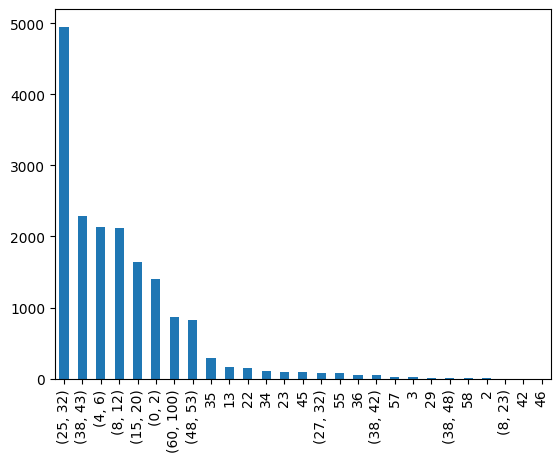

In [29]:
df_train = df_train[df_train.age != "None"]

df_train['age'].value_counts().plot(kind='bar')

x = df_train['age'].unique()
num =0
for i in x:
#     print(f"df_train.loc[(df_train.age == '{i}'),'age']='{num}'")
    num+=1
    print(i)

In [30]:
def consolidate_age(df_train):
    
    df_train.loc[(df_train.age == '(38, 42)'),'age']='(38, 43)'
    df_train.loc[(df_train.age == '(8, 12)'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '(15, 20)'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '(27, 32)'),'age']='(25, 32)'

    df_train.loc[(df_train.age == '2'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '3'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '(0, 2)'),'age']='(0, 6)'
    df_train.loc[(df_train.age == '(4, 6)'),'age']='(0, 6)'

    df_train.loc[(df_train.age == '35'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '55'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '58'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '22'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '13'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '45'),'age']='(38, 48)'
    df_train.loc[(df_train.age == '36'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '23'),'age']='(8, 23)'
    df_train.loc[(df_train.age == '57'),'age']='(55, 58)'
    df_train.loc[(df_train.age == '29'),'age']='(25, 32)'
    df_train.loc[(df_train.age == '34'),'age']='(34, 36)'
    df_train.loc[(df_train.age == '42'),'age']='(38, 48)'
    df_train.loc[(df_train.age == '46'),'age']='(38, 48)'

    df_train.loc[(df_train.age == '(38, 43)'),'age']='(38, 48)'
    
    df_train.loc[(df_train.age == '(60, 100)'),'age']=0
    df_train.loc[(df_train.age == '(48, 53)'),'age']=1
    df_train.loc[(df_train.age == '(0, 6)'),'age']=2
    df_train.loc[(df_train.age == '(38, 48)'),'age']=3
    df_train.loc[(df_train.age == '(8, 23)'),'age']=4
    df_train.loc[(df_train.age == '(34, 36)'),'age']=5
    df_train.loc[(df_train.age == '(55, 58)'),'age']=6
    df_train.loc[(df_train.age == '(25, 32)'),'age']=7
    
    df_train.loc[(df_train.gender == 'm'),'gender']=1
    df_train.loc[(df_train.gender == 'f'),'gender']=0
    

#     df_train['age'] = np.asarray(df_train['age']).astype(np.float32)
#     df_train['age'] = df_train['age'].astype(np.array)

#     df_train.loc[(df_train.age == df_train.age),'age']=df_train['age'].astype("category")
    
    return df_train

In [31]:


for fold in folds:
    fold = consolidate_age(fold)

In [32]:
df_0['age'] = np.asarray(df_0['age']).astype(np.float32)
df_1['age'] = np.asarray(df_1['age']).astype(np.float32)
df_2['age'] = np.asarray(df_2['age']).astype(np.float32)
df_3['age'] = np.asarray(df_3['age']).astype(np.float32)
df_4['age'] = np.asarray(df_4['age']).astype(np.float32)

df_0['gender'] = np.asarray(df_0['gender']).astype(np.float32)
df_1['gender'] = np.asarray(df_1['gender']).astype(np.float32)
df_2['gender'] = np.asarray(df_2['gender']).astype(np.float32)
df_3['gender'] = np.asarray(df_3['gender']).astype(np.float32)
df_4['gender'] = np.asarray(df_4['gender']).astype(np.float32)

In [33]:
import tensorflow as tf
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("age")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds


#default divisor value == 1
def embed_categorical_feature(feature, name, dataset, is_string, divisor = 1):
    lookup_class = keras.layers.StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") 

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    num_categories = lookup.vocabulary_size()
    embedded_feature = tf.keras.layers.Embedding(input_dim = num_categories+1, output_dim = math.floor(num_categories/divisor) )

    embedded_feature = embedded_feature(encoded_feature)
    embedded_feature = layers.Flatten()(embedded_feature)

    return embedded_feature

In [34]:
# age = keras.Input(shape=(1,), name="age", dtype="int64")

# train_ds = dataframe_to_dataset(df_train)

# age_embed = embed_categorical_feature(age, "age", train_ds, True)

In [35]:
# train_ds

In [36]:
import keras

In [37]:
# classes = df_train['age'].unique()

# target = df_train['age'].values
# target_classes = keras.utils.to_categorical(target, classes)

## Generate K fold dataset

In [38]:
df_0.dtypes

index                   int64
user_id                object
original_image         object
face_id                 int64
age                   float32
gender                float32
x                       int64
y                       int64
dx                      int64
dy                      int64
tilt_ang                int64
fiducial_yaw_angle      int64
fiducial_score          int64
dtype: object

In [39]:
!pip install keras_vggface

In [40]:
import keras_vggface

In [42]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(2)])
        
datagen = ImageDataGenerator(rescale=1./255)
feature_col = ['age', 'gender']
folds = [df_0, df_1, df_2, df_3, df_4]

# for fold in folds:
#     fold['age'] = fold['age'].astype("category")

fold_acc = []

# VGG 16 as base
# base_model = vgg16.vggface(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model = VGGFace(model='resnet50', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
gender_out = Dense(1,name="gender_output", activation = 'sigmoid')(x)
age_out = Dense(1,name="age_output", activation = 'softmax')(x)

model = Model(inputs=base_model.input, outputs=[age_out, gender_out])
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss={"age_output":"sparse_categorical_crossentropy", 
                    "gender_output":"binary_crossentropy"}
              ,
            metrics={'age_output': 'accuracy', 
                    'gender_output': 'accuracy'}
                    )

es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

for val_set in range(len(folds)):
    df_train = pd.DataFrame()
    # combine the other k-1 folds
    for sel_fold in range(len(folds)):
        if sel_fold == val_set:
            continue
        df_train = pd.concat([df_train,folds[sel_fold]])
    

    val_generator = datagen.flow_from_dataframe(
        dataframe=folds[val_set], 
        directory=images_folder, 
        x_col='user_id', 
        y_col=feature_col, 
        class_mode="raw", 
        target_size=(IMG_HEIGHT, IMG_WIDTH), 
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=df_train, 
        directory=images_folder, 
        x_col='user_id', 
        y_col=feature_col, 
        class_mode="raw", 
        target_size=(IMG_HEIGHT, IMG_WIDTH), 
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    hist = model.fit(
        generator_wrapper(train_generator),
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        validation_data=generator_wrapper(val_generator),
        validation_steps=val_generator.n//val_generator.batch_size,
        callbacks=[es],
        epochs=10,
        verbose=1
    )
    
    fold_acc.append(hist.history['accuracy'])

Found 3995 validated image filenames.
Found 13457 validated image filenames.
Epoch 1/10
420/420 [==============================] - 75s 173ms/step - loss: nan - age_output_loss: nan - gender_output_loss: nan - age_output_accuracy: 0.0540 - gender_output_accuracy: 0.5484 - val_loss: nan - val_age_output_loss: nan - val_gender_output_loss: nan - val_age_output_accuracy: 0.0343 - val_gender_output_accuracy: 0.4877
Epoch 2/10
420/420 [==============================] - 69s 164ms/step - loss: nan - age_output_loss: nan - gender_output_loss: nan - age_output_accuracy: 0.0542 - gender_output_accuracy: 0.5492 - val_loss: nan - val_age_output_loss: nan - val_gender_output_loss: nan - val_age_output_accuracy: 0.0343 - val_gender_output_accuracy: 0.4874
Epoch 3/10
420/420 [==============================] - 64s 153ms/step - loss: nan - age_output_loss: nan - gender_output_loss: nan - age_output_accuracy: 0.0542 - gender_output_accuracy: 0.5486 - val_loss: nan - val_age_output_loss: nan - val_gender_

KeyError: 'accuracy'

## Model creation (multi-label classification)